### 3 - Genre classification

This task is done within this notebook.

The goal is to :
- Import the libraries and load the data previously created (cf MidProjMIR-FeatureExtraction.ipynb)
- Implement several algorithms to realize our classification :
  - Supervised learning approach (Support Vector Machines)
  - Supervised learning approach (Neural Network)
  - KNN
  - LDA technique for improving KNN.
- Compare the results and try to conclude 

### 3.1 - Setup 

In this task, we are going to import the required libraries, link the colab with Google Drive and read the .csv that we generated in another Notebook.

In [24]:
# Imports 

import importlib.util

!pip install pandas
!pip install umap-learn

import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Importing from sklearn for the SVM and the KNN classifications : 
from sklearn import preprocessing
from sklearn import svm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder # Standard scaling (z-scoring) and label encoding
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, plot_confusion_matrix # For reporting accuracy
from sklearn.neighbors import KNeighborsClassifier # We will use a KNN after learning the distance metric
from sklearn.pipeline import make_pipeline

# We will use Keras for the sequential model
from keras.models import Sequential
from keras import layers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Linking with Drive
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# PATH TO BE MODIFIED
data_file = 'gdrive/MyDrive/Term2/MIR/analysis_moredescrip_split_final.csv'

In [5]:
# Read data with pandas module & plotting

data = pd.read_csv(data_file)
print(f'Our data matrix has this size : {data.shape} ; {data.shape[0]} extracts of {data.shape[1]} features.')
data.head()

Our data matrix has this size : (3687, 128) ; 3687 extracts of 128 features.


,average_loudness,barkbands_crest.mean,barkbands_crest.stdev,barkbands_flatness_db.mean,barkbands_flatness_db.stdev,barkbands_kurtosis.mean,barkbands_kurtosis.stdev,barkbands_skewness.mean,barkbands_skewness.stdev,barkbands_spread.mean,...,tonal.key_krumhansl.strength,tonal.key_temperley.strength,tonal.tuning_diatonic_strength,tonal.tuning_equal_tempered_deviation,tonal.tuning_frequency,tonal.tuning_nontempered_energy_ratio,tempo,key,genre,name
0,0.983164,15.747742,6.775431,0.160360,0.062910,12.923606,30.640085,2.617543,2.340175,26.027449,...,0.423136,0.430962,0.463353,0.244214,434.193115,0.898349,134.0,['B major'],Breaks,144851 JDS - Blackout (Original Mix).mp3
1,0.972650,14.368745,6.496716,0.146170,0.047460,6.775722,11.384822,2.090336,1.487891,22.918762,...,0.472816,0.477509,0.476100,0.226762,434.193115,0.915171,134.0,['B major'],Breaks,144851 JDS - Blackout (Original Mix).mp3
2,0.963012,11.285387,4.772082,0.200087,0.087036,1.028691,2.525684,0.965391,0.750993,16.829605,...,0.557493,0.545918,0.509812,0.140648,441.782684,0.791169,134.0,['B major'],Breaks,144851 JDS - Blackout (Original Mix).mp3
3,0.967106,16.255806,5.645452,0.295561,0.132227,29.111494,124.115662,2.847367,3.388558,11.827251,...,0.615009,0.589696,0.505482,0.203771,443.316437,0.827367,134.0,['B major'],Breaks,144851 JDS - Blackout (Original Mix).mp3
4,0.960666,12.173061,4.807395,0.248315,0.098039,2.855846,7.194796,1.197858,1.115979,14.578386,...,0.596637,0.599827,0.538145,0.258146,445.884552,0.885531,134.0,['B major'],Breaks,144851 JDS - Blackout (Original Mix).mp3


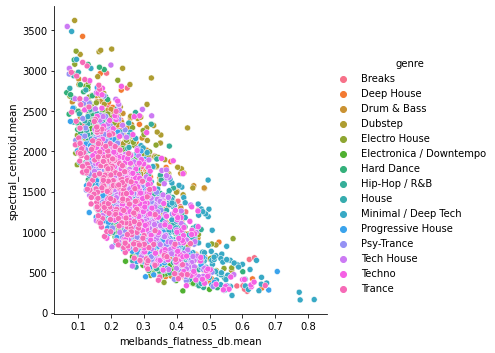

In [6]:
# Take two random features and plot the sample points
sns.relplot(x = "melbands_flatness_db.mean", y = "spectral_centroid.mean", hue = "genre", data = data);

In [7]:
# Normalizing the data using Sklearn's preprocessing tools for applying normalisation to features

data_modif = data.copy()

min_max_scaler = preprocessing.MinMaxScaler()

# We only normalize float values -> including tempo excluding key & genre
number_usable_values = 124

data_modif.iloc[:,:number_usable_values] = min_max_scaler.fit_transform(data.iloc[:,:number_usable_values].values)

### 3.2 - Supervised learning approach (Support Vector Machines)

We are first going to use the SVM method.

It's a method that can be used only for classification task.

The principle is simple : each object is represented in a n-dimensional space (n is equal to the number of features).
The SVM algorithm is going to try and find the best possible "frontier" to isolate the members of the various classes.

It is considered a "supervised learning" approach because we have to give a training set where the data is already labeled with the different categories.

Here, we have 15 classes (our different musical genres) and we have 124 dimensions (our different features).

We also need to decide on the repartition between train and test sizes.
We arbitrarily decide on a 80/20 split. Because we have almost 3500 elements in total, having nearly 700 testing elements should give representative results.

In [8]:
# Feature values put in a matrix 
X = data_modif.iloc[:,:number_usable_values].values 

# Creating output values
data_modif.genre = pd.Categorical(data_modif.genre)  # convert to categorical data
y = np.array(data_modif.genre.cat.codes)  # create label encoded outputs

# Print the first sample
print("Features of the first sample: ", X[0])
print("Class of the first sample: ", y[0])

Features of the first sample:  [0.99299305 0.6091151  0.71589799 0.15397655 0.22606665 0.01617354
 0.00529926 0.23106335 0.10338216 0.3926027  0.2845994  0.89443787
 0.16583006 0.05123024 0.19584563 0.23622539 0.11786489 0.09138074
 0.02807931 0.01437305 0.33733465 0.11744532 0.40974137 0.33668112
 0.17547877 0.07105553 0.80769445 0.02363837 0.89030881 0.00928615
 0.88137116 0.00804083 0.5001061  0.42349337 0.198134   0.22287853
 0.02205636 0.00591375 0.25163266 0.09350409 0.20086689 0.21353258
 0.42292854 0.53207345 1.         0.         0.91299305 0.56339668
 0.00142653 0.06804219 0.42003383 0.19682805 0.41670672 0.58760428
 0.91289757 0.06882617 0.08697658 0.06543527 0.14863473 0.08032262
 0.06866985 0.08266114 0.26071448 0.19883788 0.25394631 0.1169409
 0.90236551 0.10016106 0.33114965 0.14232684 0.00420253 0.00180541
 0.28652351 0.14327919 0.11757459 0.19105935 0.05720442 0.0218787
 0.53312897 0.11088661 0.06628191 0.05449676 0.19595328 0.15819954
 0.6        0.06507602 0.0612183 

In [9]:
# Let's split data into test and train sets. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

# Check sizes of input and output vectors
print("Size of train features matrix: ",X_train.shape, ", Size of train output vector: ",y_train.shape)
print("Size of test features matrix: ",X_test.shape, ", Size of test output vector: ",y_test.shape)

Size of train features matrix:  (2949, 124) , Size of train output vector:  (2949,)
Size of test features matrix:  (738, 124) , Size of test output vector:  (738,)


In [10]:
# Define and train the model
print(X_train.shape[-1]) # 86 ; makes sense.
print(X_train[0])
clf = svm.SVC(gamma = 1 / (X_train.shape[-1] * X_train.var()))

# Fit model with training data
clf.fit(X_train, y_train)

# Predict classes of test samples
y_pred = clf.predict(X_test)

124
[0.99757126 0.64823687 0.62824106 0.30638617 0.49729853 0.08425357
 0.01990504 0.39061092 0.20971275 0.29506218 0.4501833  0.82027209
 0.28422196 0.08319408 0.29439803 0.42329043 0.14581418 0.22642918
 0.06103117 0.07452625 0.40358491 0.29801098 0.5634758  0.57064771
 0.14419051 0.11440457 0.72545119 0.01336282 0.84354647 0.00743678
 0.82983397 0.00357741 0.53094501 0.56419775 0.34421247 0.50460333
 0.08255068 0.01634495 0.43189877 0.1682418  0.17222042 0.45279213
 0.4060674  0.65082605 1.         0.         0.82018562 0.76771785
 0.09129814 0.52406368 0.2747771  0.30363604 0.1655988  0.44509077
 0.89155967 0.1126108  0.10744755 0.11034005 0.14258606 0.13350631
 0.10115681 0.12118142 0.06758546 0.11738415 0.27104294 0.17275333
 0.79826622 0.42416968 0.35294277 0.31405223 0.01352457 0.03583162
 0.29481791 0.24684484 0.18994537 0.47730044 0.08342837 0.12030628
 0.61580787 0.22557176 0.07615288 0.07624516 0.20709827 0.41855555
 0.55       0.15635197 0.14187349 0.05955067 0.00410202 0.

In [11]:
# Test the model
# Let's check for each sample in the test set if prediction matches the true class information
y_test == y_pred

array([False, False,  True, False, False,  True, False, False,  True,
       False,  True,  True,  True, False, False,  True,  True,  True,
       False, False,  True,  True,  True,  True, False,  True,  True,
       False, False, False,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True, False, False,
       False,  True, False,  True, False, False, False, False,  True,
        True,  True, False,  True,  True, False,  True,  True, False,
       False,  True, False,  True, False, False, False, False, False,
       False, False,  True,  True, False,  True,  True,  True, False,
        True, False,  True,  True,  True, False, False,  True,  True,
        True, False,  True, False,  True,  True, False, False,  True,
       False, False,  True,  True, False,  True, False, False, False,
        True,  True,  True,  True, False, False, False,  True,  True,
       False, False,  True, False, False, False, False, False,  True,
       False,  True,

In [12]:
# The data is balanced, so we can use accuracy as a measure:
print("accuracy: ", np.sum(y_test == y_pred)/len(y_test))

accuracy:  0.42276422764227645


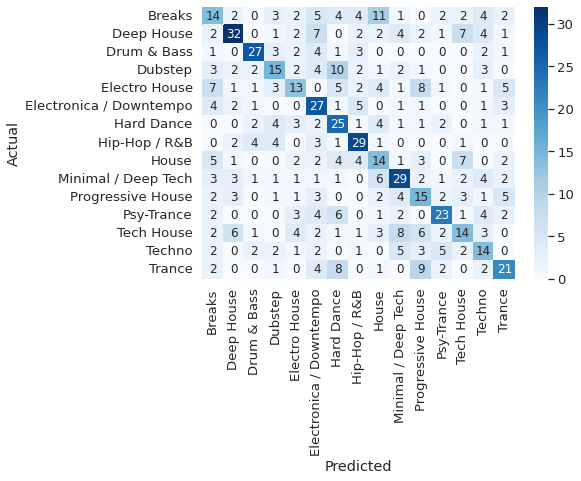

In [13]:
# Print the confusion matrix


classes = np.unique(data_modif.genre)
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = classes, index = classes)
conf_mat.index.name = 'Actual'
conf_mat.columns.name = 'Predicted'
plt.figure(figsize = (7, 5))
sns.set(font_scale = 1.2)
sns.heatmap(conf_mat, cmap = "Blues", annot_kws = {"size": 12}, annot = True);

We have those results for the SVM method. 
An accuracy of 42% seems not a lot but by including more features (rhythm and tonal) and by dividing the data into smaller elements, we basically doubled the accuracy. (It was previously roughly 20%).

If we had a "model" that consisted of randomly assigning a class to a sample, we would have 1/15 ~= 6.67% accuracy. 
Here, we have nearly 7 times this accuracy. It's the proof that this model, even thought not perfect has some interesting & relevant results. But it still can be largely improved.

### 3.3 - Supervised learning approach (Neural Network)

Here, we are going to implement another supervised learning method : a Neural Network.

This neural network is going to be a simple Sequential model made with Keras. Keras is an high-level API running on top of TensorFlow. It helps to quickly prototype a neural network that can act as a proof of concept.

### 3.3.1 - Designing the model

We are going to have 4 layers : 
* Input layer : This layer has a number of input equal to the number of features that we extracted : 124.
* Hidden layers : Those layers are going to be used to slowly but surely reduce the number of features. Since 124/4 ~= 15, we are going to divide by 2 the number of neurons in every layer.
  * #1 : We are going to have 60 neurons in this layer. Activation : tanh 
  * #2 : We are going to have 30 neurons in this layer. Activation : ReLU.
* Output layer : This layer has 15 elements : our 15 classes.

For each layer, we are going to have a Dropout rate. This value means that randomly select neurons will be ignored during training. Their contribution to the activation of downstream neurons is temporally removed and they will not be affected by backward pass.

This aims at preventing an eventual overfitting, because when a neuron is dropped out, other neurons have to step in and handle the data for the missing neurons. This results in a network less sensitive to the specific wieght of neurons and therefore capable of better generalization and therefore less overfitting.

For our study after several trials, we are going to chose a rate of 0.3.

Each hidden layer also has an activation function. This function is responsible for transforming the output of each neuron to introduce non-linearity.
We use 2 functions here : 
* tanh : maps its input to the range of [-1,1]. This function works really well for values near 0.0, but tend to saturate when we reach the limits (-1 and 1). 
* ReLU : maps its input to the range of [0; inf]. It is computationally efficient and can help solve the "vanishing gradient problem". 

Combining those 2 functions in the same model can be beneficial as it allows the model to learn a complex and diverse set of representations.

In [14]:
# Let's start by splitting our data 
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.20, random_state = 1)

# ..and apply normalisation
scaler = StandardScaler().fit(X_train_val)
norm_x_train_val = scaler.transform(X_train_val)
norm_x_test = scaler.transform(X_test)

In [15]:
onehot_encoder = OneHotEncoder(sparse=False)
y_train_val_onehot = onehot_encoder.fit_transform(y_train_val.reshape(len(y_train_val), 1))
y_test_onehot = onehot_encoder.fit_transform(y_test.reshape(len(y_test), 1))
print("One-hot encoded y_train_val shape = ", y_train_val_onehot.shape)
print("One-hot encoded y_test shape = ", y_test_onehot.shape)

One-hot encoded y_train_val shape =  (2949, 15)
One-hot encoded y_test shape =  (738, 15)


In [16]:
# Defining the model 

def compose_model(num_features):
    
    model = Sequential()

    # Input layer 
    model.add(layers.BatchNormalization(name='InputLayer', input_shape=(num_features,)))
    
    # 1. hidden layer
    model.add(layers.Dense(name='HiddenLayer_1', units = 60)) #40
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('tanh'))
    model.add(layers.Dropout(0.30))

    # 2. hidden layer
    model.add(layers.Dense(name='HiddenLayer_2', units = 30)) #20
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.30))

    # Output layer
    model.add(layers.Dense(name='Output_layer', units = 15))
    model.add(layers.Activation('sigmoid'))
    
    return model

model = compose_model(X_train_val.shape[1])

In [17]:
model.summary()  # Plot summary of the model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (BatchNormalizat  (None, 124)              496       
 ion)                                                            
                                                                 
 HiddenLayer_1 (Dense)       (None, 60)                7500      
                                                                 
 batch_normalization (BatchN  (None, 60)               240       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 60)                0         
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 HiddenLayer_2 (Dense)       (None, 30)                1

### 3.3.2 - Training the model

After designing the model, we are going to train it.
We have the following parameters :
* batch_size : Value corresponding to the amount of dataset samples to be processed in one forward/backward pass through the network. It has an impact on training time and memory usage of the model. We are going to choose a batch_size of 64
* epochs : Value corresponding to the amount of times we are going to pass over the entire dataset. The more iteration the more precise our model will be, but also the more training time it takes. We are going to choose an number of epochs of 250.
* validation_split : Same as the SVM, we are going to split our data with a classical 80/20 ratio.

In [18]:
# Training the model

model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
summary = model.fit(X_train_val, y_train_val_onehot, batch_size = 64, epochs = 250, validation_split=0.2, verbose=0)

In [19]:
score = model.evaluate(X_test, y_test_onehot, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.14436253905296326
Test accuracy: 0.5582655668258667


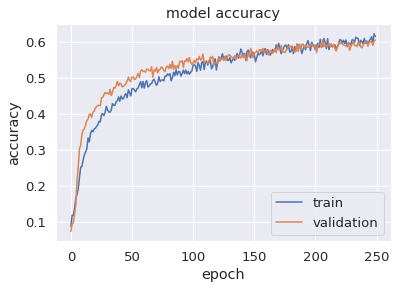

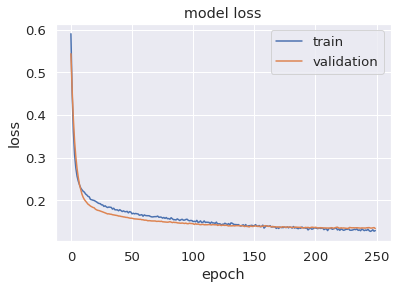

In [20]:
# summarize history for accuracy
plt.plot(summary.history['accuracy'])
plt.plot(summary.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(summary.history['loss'])
plt.plot(summary.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### 3.3.3 - Results & Analysis

We can see that with set of parameters, we reach a 55% accuracy, which is better than with the SVM. 

We try various configurations, and this is the results that we obtained :
* With 124/40/20/15 : 51% accuracy
* With 124/60 (tanh) /30 (ReLu) /15 : 55% accuracy
* With 124/60/30/20/15 : 52% accuracy.
* With 124/60/40/30/20/15 : 47% accuracy
* With 124/60/30/15 and dropout of 0.1 : 58% accuracy - but serious overfitting.
* With 124/60/30/15 and dropout of 0.2 : 55% accuracy and still some overfitting 
* ... 

We see that our results are quite similar, and always around the 50-60% accuracy. 

There is probably a way to improve a lot the accuracy of our model with the right choice of parameters (number of layers, number of neurons, activation functions and dropout rates).

Creating more samples and adding the tonal and the rhythm features helped to go from 20-30% accuracy (before) to nearly 50-55% now. 

Upon trying several set of parameters, we notice that for some of them, we have some serious overfitting, with close to 90% accuracy for the training set and 60% for the validation set. 

Playing with the parameters still gives us around 50-60% accuracy but more or less overfitting, which is something that we try to get rid of.

With our final set of parameter, we have nearly 55% accuracy and our graph shows a slight overfitting. The number of epochs should be reduced to nearly 150.

### 3.4 - Classification using KNN

We are now going to use the K-Nearest Neighbors (KNN) Algorithm in our data.

This algorithm consists in placing the samples in a n-dimensional space based on their features, computing the distance between a sample and every other one.

When a new element is introducing (here : the testing set), it is placed on the n-dimension space and is classified according to the K closest elements in the space. 

The main advantages of this algorithm is its simplicity and the possibility to work a lot of type of data. However, computation can take longer and longer with the growth of the dataset size.

Before actually releasing the classification, we are going to have a standardization step. The `StandardScaler()` is going to do this, by substracting the mean and dividing by the standard deviation. It is going to ensure that the data has zero mean and unit variance, which is going to improve the performance of the KNN algorithm.

In [21]:
# scaling followed by KNN in a pipeline process
clf = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=10))

# Fit all stages of the pipeline to our training data
clf.fit(X_train, y=y_train)

# How well does our 1-Nearest neighbor model work?
y_pred = clf.predict(X_test)

In [22]:
# testing, the model. Because the data is balanced, we can use accuracy as a measure
y_test == y_pred
print("accuracy: ", np.sum(y_test == y_pred)/len(y_test))

accuracy:  0.6016260162601627


                         precision    recall  f1-score   support

                 Breaks       0.40      0.65      0.49        54
             Deep House       0.55      0.64      0.59        53
            Drum & Bass       0.80      0.76      0.78        54
                Dubstep       0.61      0.57      0.59        49
          Electro House       0.46      0.52      0.49        56
Electronica / Downtempo       0.59      0.73      0.65        45
             Hard Dance       0.65      0.58      0.61        45
          Hip-Hop / R&B       0.69      0.84      0.76        45
                  House       0.50      0.60      0.54        47
    Minimal / Deep Tech       0.83      0.68      0.75        50
      Progressive House       0.51      0.48      0.50        52
             Psy-Trance       0.78      0.56      0.65        50
             Tech House       0.66      0.45      0.54        42
                 Techno       0.81      0.50      0.62        58
                 Trance 

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


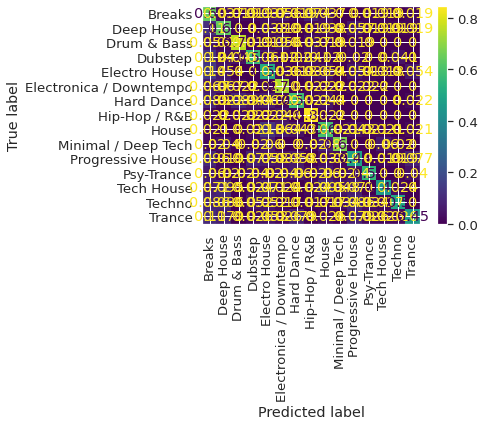

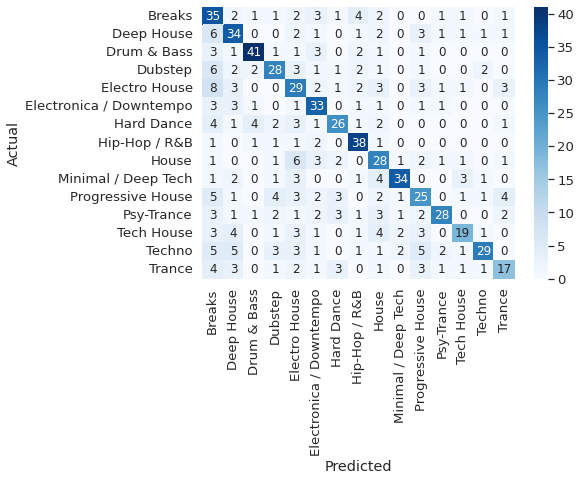

In [25]:
# Compare the predictions to the true labels in y_test
classes = np.unique(data_modif.genre)
report = classification_report(y_test, y_pred, target_names=classes)

print(report)

# Finally, plot a confusion matrix showing how mistakes are distributed
plot_confusion_matrix(clf, X_test, y_test, display_labels=classes, xticks_rotation='vertical', normalize='true');

conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = classes, index = classes)
conf_mat.index.name = 'Actual'
conf_mat.columns.name = 'Predicted'
plt.figure(figsize = (7, 5))
sns.set(font_scale = 1.2)
sns.heatmap(conf_mat, cmap = "Blues", annot_kws = {"size": 12}, annot = True);

We run the KNN algorithm for several K : 
* K=1 : 68% accuracy
* K=2 : 60% accuracy
* K=3 : 58% accuracy
* K=10 : 51% accuracy

We can see that we have the biggest accuracy for K = 1.
However, this means that our model is sensitive to noise and outliers.

### 3.5 - Feature Visualization - Linear Discriminant Analysis

We are going to use a technique called Linear Discriminant Analysis (LDA) which consists in a dimensionality reduction.

It is a supervised learning method that finds a linear combination of features that best separates two or more classes of data. In our case, it is going to try to separate 15 classes.

The goal is to project a high-dimensional data space (here, our 124 space) into a lower-dimensional space (here, 15).

LDA can improve the accuracy and interpretability of the classifier.

It works well then the data are well-separated and when the features are uncorrelated. However, it might perform poorly if the classes overlap or if the features are highly correlated.

### 3.5.1 - Basic visualisation

Here, we do a basic data visualisation before applying LDA.

In [26]:
### How to visualize features using metric learning https://github.com/bmcfee/ismir2020-metric-learning
# scikit-learn provides Linear discriminant analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Finally, umap will let us map high-dimensional data down to 2-d for plotting
import umap

In [27]:
reducer = umap.UMAP(random_state=42)

# We'll apply all but the last stage (KNN classifier) of our pipeline to the data.
# In this case, we just have one previous stage, which does feature normalization.
# This will change in subsequent examples.

X_train_transformed = clf[:-1].transform(X_train)
X_test_transformed = clf[:-1].transform(X_test)

# Fit on the transformed data, and then transform the test data
embed = reducer.fit_transform(X_train_transformed)
embed_test = reducer.transform(X_test_transformed)

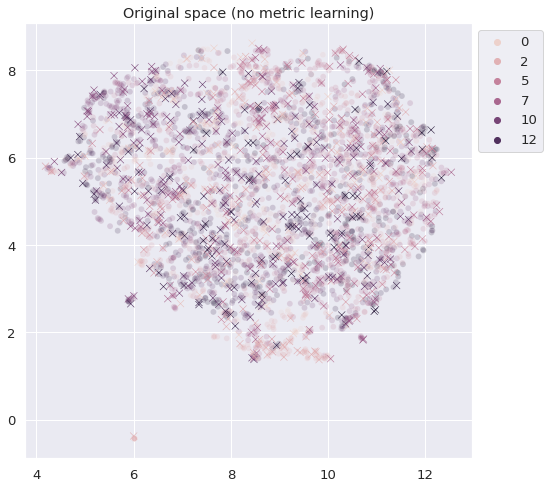

In [28]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x=embed[:, 0], y=embed[:, 1], hue=y_train, marker='o', alpha=0.2, legend=None, ax=ax)
sns.scatterplot(x=embed_test[:, 0], y=embed_test[:, 1], hue=y_test, marker='x', s=50, alpha=1, legend='brief', ax=ax)
ax.legend(bbox_to_anchor=(1, 1));
ax.set(title='Original space (no metric learning)');

### 3.5.2 - Visualisation with LDA

Here, we compute the LDA algorithm on our data and we try to visualise the results.

[Pipeline] .... (step 1 of 3) Processing standardscaler, total=   0.0s
[Pipeline]  (step 2 of 3) Processing lineardiscriminantanalysis, total=   0.1s
[Pipeline]  (step 3 of 3) Processing kneighborsclassifier, total=   0.0s
                         precision    recall  f1-score   support

                 Breaks       0.94      0.89      0.91        54
             Deep House       0.96      0.87      0.91        53
            Drum & Bass       0.94      0.94      0.94        54
                Dubstep       0.98      0.92      0.95        49
          Electro House       0.88      0.91      0.89        56
Electronica / Downtempo       0.90      0.82      0.86        45
             Hard Dance       0.95      0.87      0.91        45
          Hip-Hop / R&B       0.86      0.98      0.92        45
                  House       0.92      0.94      0.93        47
    Minimal / Deep Tech       0.90      0.88      0.89        50
      Progressive House       0.90      0.90      0.90       

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


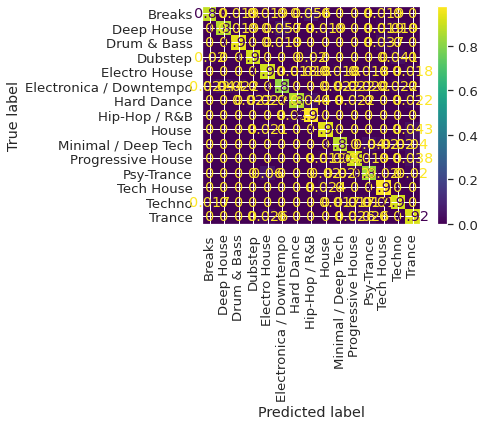

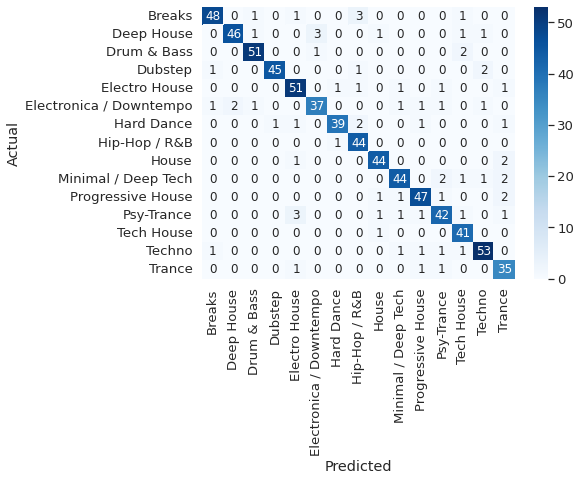

In [29]:
# scaling followed by KNN in a pipeline process

clf = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(), KNeighborsClassifier(n_neighbors=1), verbose=True)
clf.fit(X_train, y=y_train)

y_pred = clf.predict(X_test)

report = classification_report(y_test, y_pred, target_names=classes)

print(report)

plot_confusion_matrix(clf, X_test, y_test, display_labels=classes, xticks_rotation='vertical', normalize='true')

conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = classes, index = classes)
conf_mat.index.name = 'Actual'
conf_mat.columns.name = 'Predicted'
plt.figure(figsize = (7, 5))
sns.set(font_scale = 1.2)
sns.heatmap(conf_mat, cmap = "Blues", annot_kws = {"size": 12}, annot = True);

In [31]:
reducer = umap.UMAP(random_state=42)

# We'll fit the umap embedding on the data after applying our learned transformation
embed = reducer.fit_transform(clf[:-1].transform(X_train))
embed_test = reducer.transform(clf[:-1].transform(X_test))

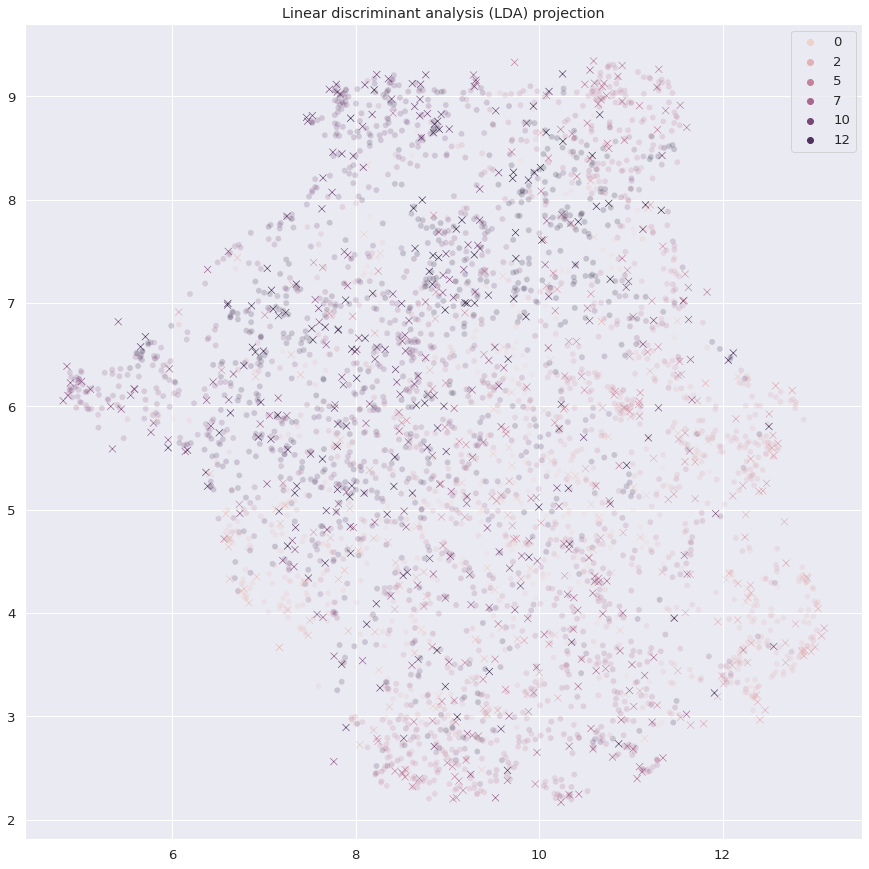

In [32]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.scatterplot(x=embed[:, 0], y=embed[:, 1], hue=y_train, marker='o', alpha=0.2, legend=None, ax=ax)
sns.scatterplot(x=embed_test[:, 0], y=embed_test[:, 1], hue=y_test, marker='x', s=50, alpha=1, legend='brief', ax=ax)
ax.legend(bbox_to_anchor=(1, 1));
ax.set(title='Linear discriminant analysis (LDA) projection');

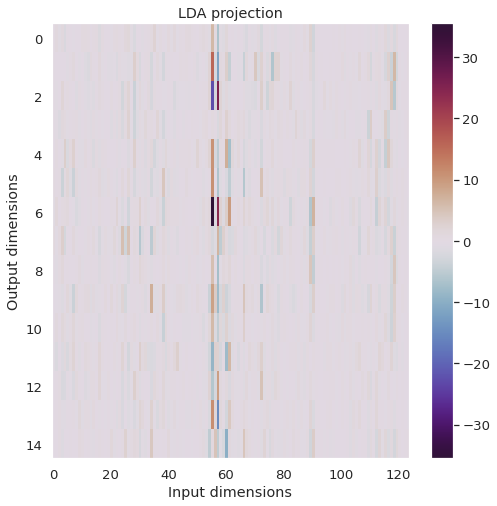

In [33]:
fig, ax = plt.subplots(figsize=(8, 8))
model = clf.steps[1][1]
weights = model.coef_

img = ax.imshow(weights, cmap='twilight_shifted', vmin=-np.abs(weights).max(), vmax=np.abs(weights).max(), aspect='auto', interpolation='none')
fig.colorbar(img, ax=ax)
ax.grid(False)
ax.set(xlabel='Input dimensions', ylabel='Output dimensions', title='LDA projection');

In [34]:
# We print the most important weights for each class (for LDA method)

for i in range(len(weights)):
  print(f'For class n°{i+1}')
  print(data.columns[:number_usable_values][weights[i]>3])
  print('---')

For class n°1
Index(['spectral_decrease.stdev'], dtype='object')
---
For class n°2
Index(['loudness_ebu128.momentary.mean', 'spectral_decrease.stdev',
       'spectral_energyband_low.mean', 'spectral_kurtosis.mean',
       'tonal.key_krumhansl.strength'],
      dtype='object')
---
For class n°3
Index(['spectral_energy.stdev', 'spectral_rms.mean',
       'tonal.key_edma.strength'],
      dtype='object')
---
For class n°4
Index(['tonal.hpcp_crest.var', 'tonal.hpcp_entropy.stdev'], dtype='object')
---
For class n°5
Index(['barkbands_flatness_db.stdev', 'loudness_ebu128.momentary.mean',
       'spectral_decrease.stdev', 'spectral_energyband_low.mean',
       'tonal.hpcp_entropy.var'],
      dtype='object')
---
For class n°6
Index(['melbands_skewness.mean', 'spectral_decrease.stdev',
       'spectral_rms.mean'],
      dtype='object')
---
For class n°7
Index(['spectral_energy.stdev', 'spectral_energyband_low.mean',
       'spectral_energyband_low.stdev', 'rhythm.bpm_histogram_first_peak_bpm'

### 3.5.3 - Conclusion

Applying the LDA technique to our dataset showed impressive results, by increasing our accuracy from 70% to nearly 90%.

# 4 - Conclusion

We have seen several classifications methods, each one of them having qualities, defaults and different results :
* SVM : 42% accuracy
* Sequential model (Neural Network) : 60% accuracy
* KNN : 68% accuracy but very sensitive to noise and outliers
* KNN with LDA : Nearly 90% accuracy

It is probably possible to improve the results of every model by curating a more precise set of features and creating more data (adding more data to the dataset or dividing in even more smaller samples the data, while making sure that they contain enough relevant elements of the track). 

Regarding the features, the LDA technique helps us to visualise interesting features. A method to improve the accuracy could be to select those features and apply the various algorithms on them, refining the parameters of the models. Less features means a quicker training and less "non-linearity". Since we work on machine learning method and not deep learning, having some linearity could improve our results. 